In [1]:
import torch
import matplotlib.pyplot as plt
from data_generation import data_generator
from neuralop.models import FNO
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss, Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# %% data_generation
train_loader, test_loaders, data_processor = data_generator(1000,50)
data_processor = data_processor.to(device)
# %%
model = FNO(n_modes=(2, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')

# %%
optimizer = torch.optim.Adam(model.parameters(),
                             lr=8e-3,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# %%
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = l2loss
eval_losses = {'h1': h1loss, 'l2': l2loss}

# %%
trainer = Trainer(model=model,
                  n_epochs=500,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)


Our model has 92985 parameters.
self.override_load_to_device=False
self.overrides_loss=False


In [3]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

{'32_h1': 1.1745653533935547, '32_l2': 2.346102600097656}

In [4]:
import math

# %%
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(1):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    # print(x.shape, y.shape)
    out = model(x.unsqueeze(0))
    x_ = x[0].reshape(-1).cpu().numpy()
    print('x_shape:',x_.shape)
    y_ = y[0].reshape(-1).cpu().numpy()
    out_ = out[0].reshape(-1).squeeze().detach().cpu().numpy()
    
    # print('x_:',x_)
    print('y_:',y_)
    print('out_:',out_)
    lp_loss = LpLoss(d=2, p=2, L=2*math.pi, reduce_dims=0, reductions='sum')
    relative_loss = lp_loss(y, out)
    print('re=',relative_loss.item())



x_shape: (32,)
y_: [-0.66229767  0.29545984 -0.21101423 -0.13454367 -0.08070672  2.604782
  0.3060353  -0.48852694 -0.31076944  1.0228616  -0.589906   -0.25526908
 -0.6973966  -0.7008685  -0.04538341 -0.6711143   0.47808242 -0.53401333
  1.1219093  -0.59594375 -0.3359035  -0.66780263  3.329763   -0.68013525
  1.4045876  -0.31534523 -0.5876913   0.54913473 -0.01524487 -0.45669934
  1.8087821   0.6755798 ]
out_: [-2.600816   -1.8937299  -2.2827263  -2.208089   -2.1667116  -0.29035807
 -1.9088478  -2.4807122  -2.3495524  -1.3944613  -2.544297   -2.3115513
 -2.6074235  -2.6177366  -2.1352785  -2.6048224  -1.7658601  -2.5066078
 -1.3294904  -2.5576224  -2.3496308  -2.6041174   0.21835977 -2.5900242
 -1.1163775  -2.3530474  -2.5427601  -1.7356611  -2.1474824  -2.4552295
 -0.8455     -1.6406931 ]
re= 1.0212206840515137


<Figure size 700x700 with 0 Axes>

torch.Size([1, 1, 2, 16])
torch.Size([1, 1, 2, 16])
torch.Size([1, 1, 2, 16])


C:\Users\huaitaozhu\AppData\Local\Temp\ipykernel_6784\1811487497.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


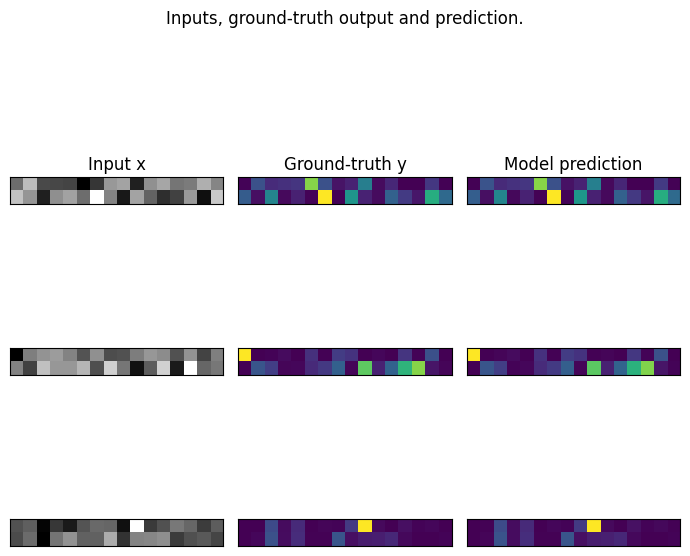

In [5]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0].cpu().numpy(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze().cpu().numpy())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.squeeze().detach().cpu().numpy())
    print(out.shape)
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()


torch.Size([3, 2, 16]) torch.Size([1, 1, 2, 16])
x_shape: (32,)


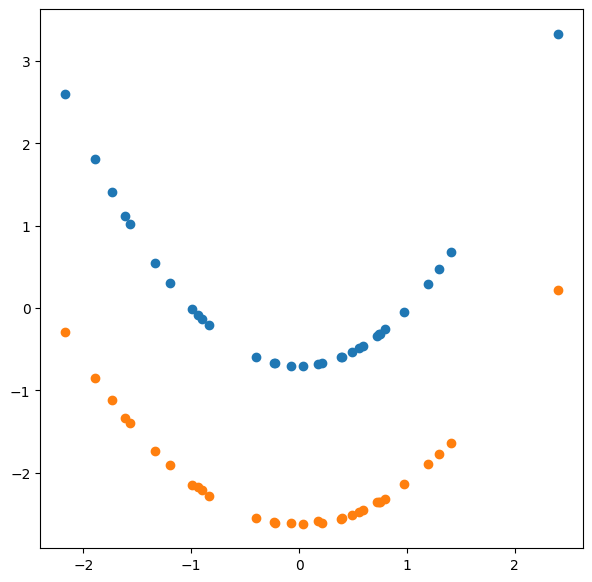

In [6]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(1):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    print(x.shape, y.shape)
    out = model(x.unsqueeze(0))
    x_ = x[0].reshape(-1).cpu().numpy()
    print('x_shape:',x_.shape)
    y_ = y[0].reshape(-1).cpu().numpy()
    out_ = out[0].reshape(-1).squeeze().detach().cpu().numpy()
    
    plt.scatter(x_, y_)
    plt.scatter(x_, out_)